# Síťová analýza PID

In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.cm as cm


import collections
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [137]:
pid = pd.read_csv("d.csv")

## Předzpracování dat

Za jedinečný identifikátor zastávky můžete považovat **název zastávky**. Pozor na stejné názvy zastávek pro různé dopravní prostředky - u takových zastávek můžete uvažovat, že se jedná o jednu a tutéž stanici (v mnoha případech to i platí). 

In [138]:
pid.head()

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


In [139]:
def adjust_times(df, col):
    time_split = df[col].str.split(":", expand=True)
    hours = time_split[0].astype(int) % 24 
    minutes = time_split[1]
    seconds = time_split[2]

    df[col] = pd.to_datetime(
        hours.astype(str) + ":" +
        minutes + ":" +
        seconds,
        format="%H:%M:%S"
    ).dt.time
    return df

In [140]:
pid_copy = pid.copy()
pid_copy = adjust_times(pid_copy, "depart_from")
pid_copy = adjust_times(pid_copy, "arrive_to")
display(pid_copy.info())
pid_copy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


None

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,04:53:00,04:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,04:54:30,04:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,04:56:00,04:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,04:59:00,05:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,04:36:00,04:38:00,2,0,1,1,1,1,1,0,0


In [141]:
pid = pid_copy

## Základní síťová analýza

1. filtrace, tramvaje
2. nahrani do balicku networkX
3. vizualizace grafu, vyuziju lokacni data ze stops
4. 3 mery centrality
5. 1 z nich vizualizovat

4 = privoz

3 = trolejbusy

2 = 

1 = metro

0 = tramvaje

Vizualizuji síť tramvají. Popisky statnic nechám u koncových stanic a stanic, které kolem sebe nemají hodně dalších stanic a jejich název je kratší než 9 písmen (kvůli čitelnosti). Vrcholy jsou rozmístěny v grafu na základě geografické polohy z datasetu stops.csv. Pro vyřešení problému různých lokací zastávek se stejným názvem jsem zvolil zprůměrování poloh po složkách. Považuji tedy název za unikátní identifikátor. Z lokačních dat jsem vybral jen zastávky, které se týkají tramvají.

In [ ]:
def initialize_graph(df):
    G = nx.DiGraph()

    for index, row in df.iterrows():
        stop_from = row['stop_from_name']
        stop_to = row['stop_to_name']
        weight = row['monday'] + row['tuesday'] + row['wednesday'] + row['thursday'] + row['friday'] + row['saturday'] + row['sunday']

        if G.has_edge(stop_from, stop_to):
            G[stop_from][stop_to]['weight'] += weight
        else:
            G.add_edge(stop_from, stop_to, weight=weight)
    return G

In [143]:
tram_df = pid[pid["route_type"] == 0] 
G_tram_subgraph = initialize_graph(tram_df)

In [144]:
stops = pd.read_csv("stops.csv")

In [250]:
tram_stops = set(tram_df['stop_from']).union(set(tram_df['stop_to']))
filtered_stops = stops[stops['stop_id'].isin(tram_stops)]


mean_loc = filtered_stops.groupby("stop_name").apply(
    lambda x: pd.Series({
        "mean_lat": x["stop_lat"].mean(),
        "mean_lon": x["stop_lon"].mean()
    })
).reset_index()

pos = mean_loc.set_index("stop_name")[["mean_lat", "mean_lon"]].to_dict("index")
pos = {key: (value["mean_lon"], value["mean_lat"]) for key, value in pos.items()}

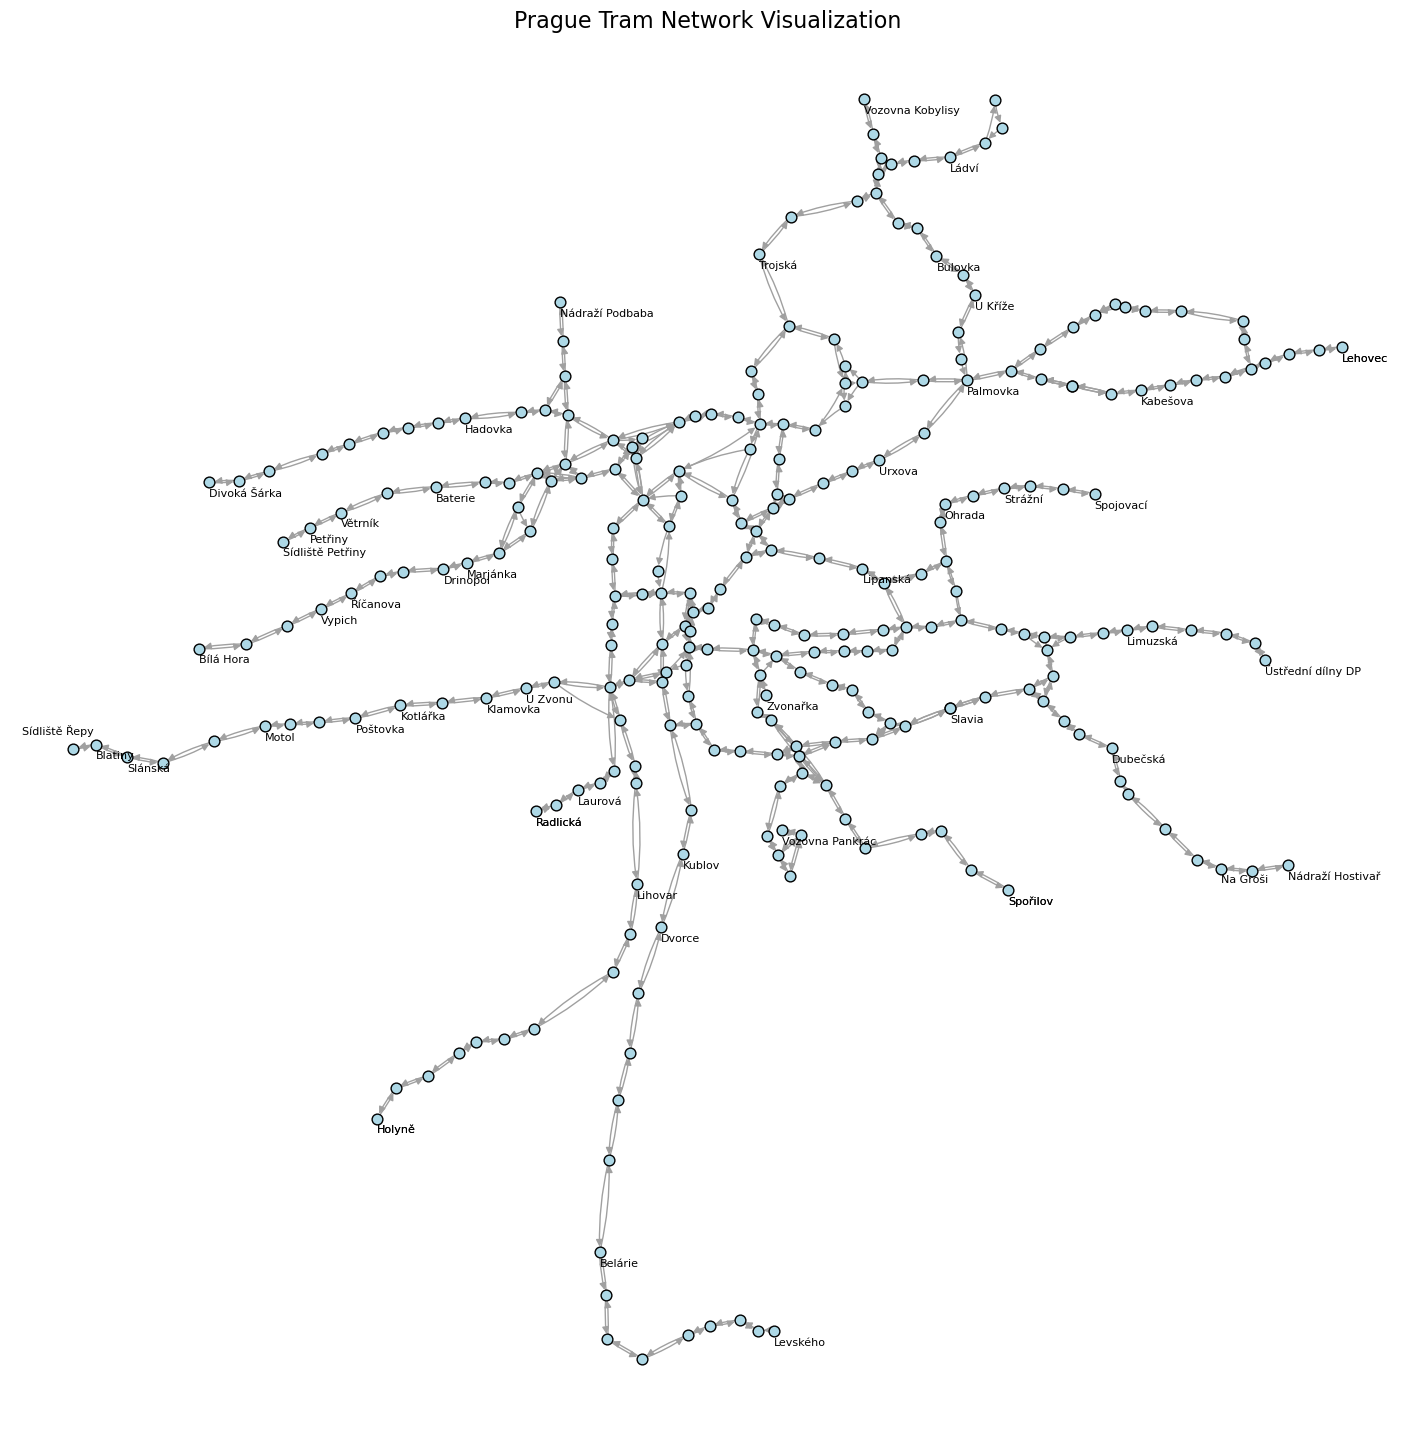

In [325]:
fig, ax = plt.subplots(figsize=(18, 18))

vicinity_radius = 0.008
coords = mean_loc[['mean_lon', 'mean_lat']].values
nbrs = NearestNeighbors(radius=vicinity_radius).fit(coords)
distances, indices = nbrs.radius_neighbors(coords)

filtered_nodes = []
for i, neighbors in enumerate(indices):
    if len(neighbors) < 5:  
        filtered_nodes.append(mean_loc.iloc[i]['stop_name'])

alone_nodes = []
for node in G_tram_subgraph.nodes:
    if G_tram_subgraph.in_degree(node) == 1 and G_tram_subgraph.out_degree(node) == 1:
        successors = list(G_tram_subgraph.successors(node))
        predecessors = list(G_tram_subgraph.predecessors(node))
        if successors == predecessors:
            if len(successors) == 1:
                alone_nodes.append(node)

nx.draw_networkx(
    G_tram_subgraph,
    pos=pos,
    ax=ax,
    node_size=60,
    node_color='lightblue',
    edgecolors='black',  
    edge_color='#a0a0a0',
    arrowstyle='-|>',
    arrows=True,
    connectionstyle='arc3,rad=0.07',
    with_labels=False
)

label_length_threshold = 9
for node in filtered_nodes:
    if len(node) < label_length_threshold:  
        x, y = pos[node]
        radius = 0.0015
        angle = (3*np.pi)/2
        x_offset = radius * np.cos(angle)
        y_offset = radius * np.sin(angle)
        plt.text(
            x + x_offset, y + y_offset, node,
            fontsize=8,
            color='black'
        )

for node in alone_nodes:
    x, y = pos[node]
    radius = 0.0015
    angle = (3*np.pi)/2
    x_offset = radius * np.cos(angle)
    y_offset = radius * np.sin(angle)
    if(node == "Sídliště Řepy"):
        x_offset = -0.01
        y_offset = 0.0015
    plt.text(
        x + x_offset, y + y_offset, node,
        fontsize=8,
        color='black'
    )


plt.title("Prague Tram Network Visualization", fontsize=16)
plt.margins(0)
plt.axis("off")
plt.show()

3 měry centrality

In [328]:
# Print the first 10 edges from the graph
edges = list(G_tram_subgraph.edges(data=True))[:10]
for edge in edges:
    print(edge)

('Vozovna Motol', 'Motol', {'weight': 5264})
('Vozovna Motol', 'Hotel Golf', {'weight': 4890})
('Motol', 'Krematorium Motol', {'weight': 5264})
('Motol', 'Vozovna Motol', {'weight': 4890})
('Krematorium Motol', 'Hlušičkova', {'weight': 5264})
('Krematorium Motol', 'Motol', {'weight': 5153})
('Hlušičkova', 'Slánská', {'weight': 5264})
('Hlušičkova', 'Krematorium Motol', {'weight': 5153})
('Slánská', 'Blatiny', {'weight': 5264})
('Slánská', 'Hlušičkova', {'weight': 5153})


In [ ]:
between_centrality = dict(sorted(nx.betweenness_centrality(G_tram_subgraph).items(), key=lambda item: item[1], reverse=True))
between_centrality.values()

dict_values([0.3411205249670113, 0.2809070798846151, 0.2709754949991128, 0.2669918994429367, 0.2507858151761762, 0.2419822123316749, 0.2120394752883232, 0.21180282815267482, 0.19318814601936793, 0.19146014678272746, 0.1908386216815559, 0.18357387405150455, 0.17152953456908906, 0.16803967566256342, 0.16756981448033673, 0.16432779365767075, 0.1461341525857655, 0.14104096606016706, 0.1388938318181792, 0.13504821641918419, 0.13098266899582173, 0.12991188769414588, 0.1286787780547383, 0.1276121345514584, 0.12502684655334445, 0.12204653136872817, 0.12111415423627378, 0.12104444818778526, 0.12001640153809892, 0.11481702877824232, 0.11169255823825713, 0.10947190798477277, 0.10783671234324087, 0.1077379965748821, 0.10716960210239776, 0.1068623824403394, 0.10580398053900364, 0.1052900094230739, 0.10455141177875427, 0.10318193355827761, 0.10173371506032787, 0.10094328752546874, 0.09894222563577419, 0.09837429595494111, 0.09516129032258064, 0.09514486260453985, 0.09195582842088218, 0.0919354838709

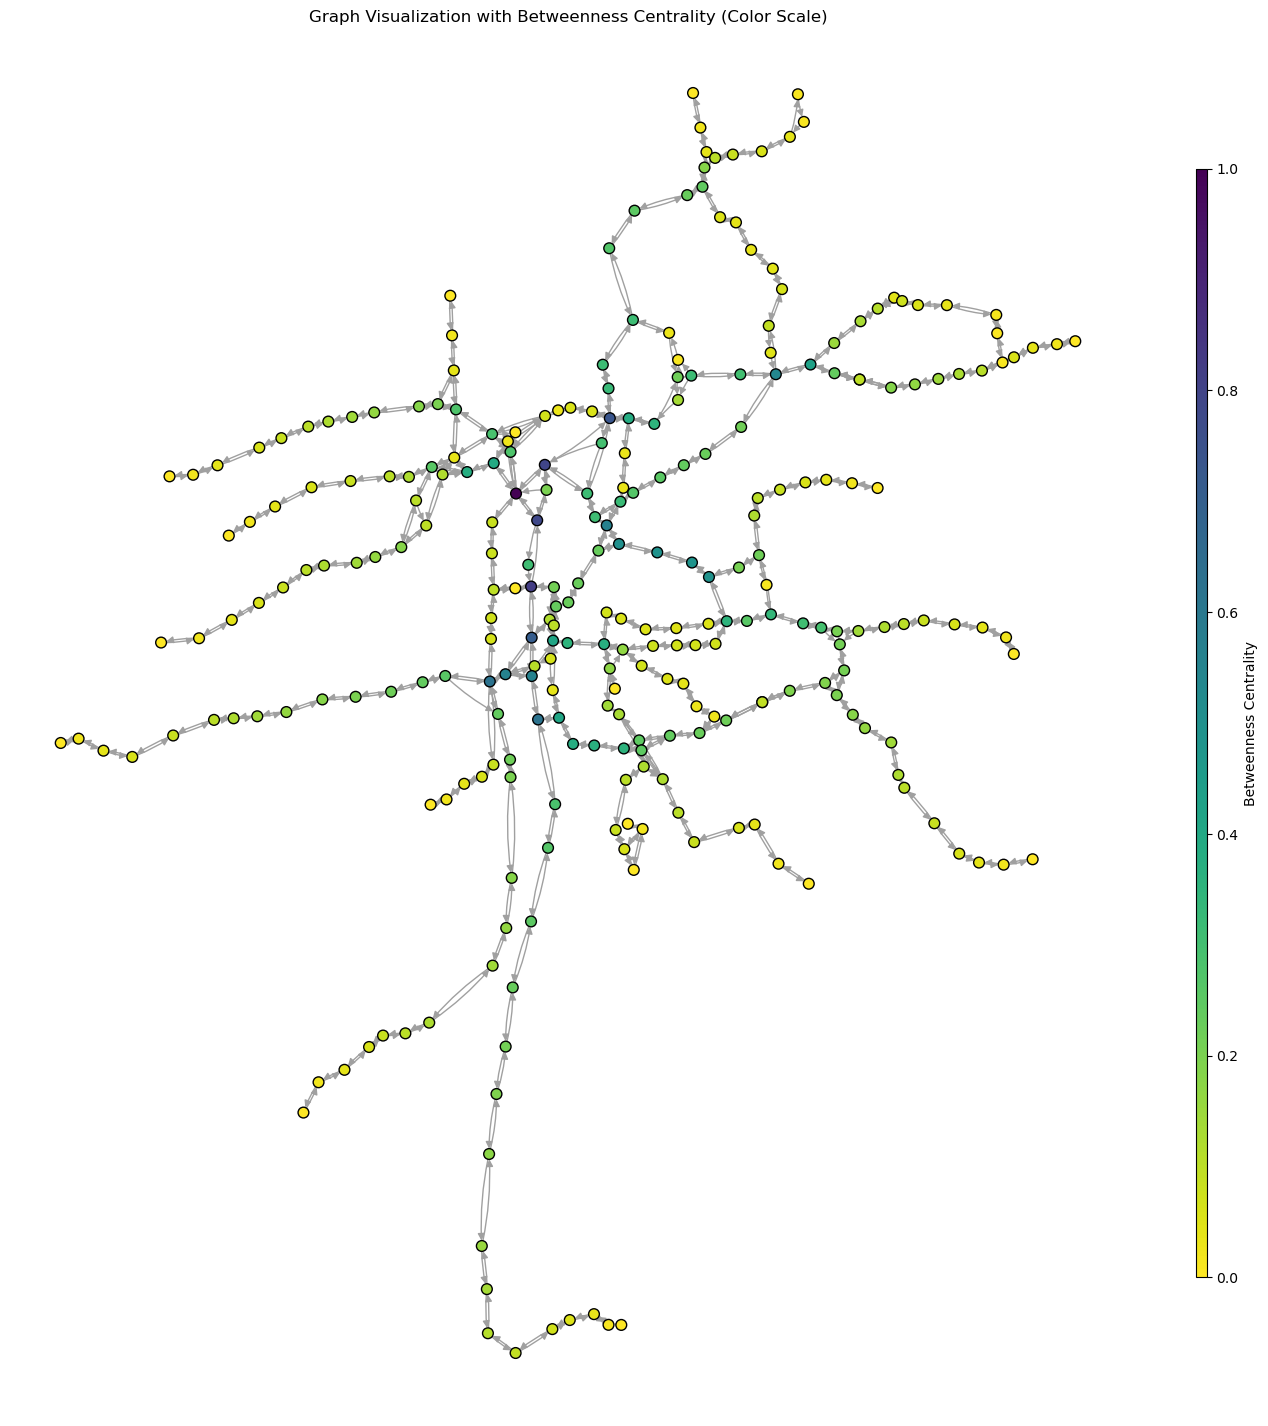

In [344]:
fig, ax = plt.subplots(figsize=(18, 18))


node_color = [between_centrality[node] for node in G_tram_subgraph.nodes()]
cmap = cm.get_cmap('viridis_r')
norm = plt.Normalize(vmin=min(node_color), vmax=max(node_color))

nx.draw_networkx(
    G_tram_subgraph,
    pos=pos,
    ax=ax,
    node_size=60,
    node_color=node_color,
    edgecolors='black',  
    edge_color='#a0a0a0',
    arrowstyle='-|>',
    arrows=True,
    cmap=cmap,
    connectionstyle='arc3,rad=0.07',
    with_labels=False
)

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label='Betweenness Centrality', shrink=0.8, aspect=100) 

plt.title("Graph Visualization with Betweenness Centrality (Color Scale)")

plt.margins(0)
plt.axis("off")
plt.show()